In [99]:
print(5)

5


In [100]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
url = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1550000000&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true"
response = requests.get(url)
response.text
df = pd.read_csv(StringIO(response.text),index_col = "Date",parse_dates = ["Date"])
df_plot = df[{'Open','High','Low','Close'}]

In [101]:
#計算ma
def moving_average(data,periods):
    return data['Close'].rolling(periods).mean()

In [102]:
df_copy = df.copy()
df_copy['min'] = df_copy['Low'].rolling(9).min()
df_copy['max'] = df_copy['High'].rolling(9).min()
df_copy['RSV'] = (df_copy['Close'] - df_copy['min']) / (df_copy['max'] - df_copy['min'])
df_copy = df_copy.dropna()
K_list = [50]
for index,rsv in enumerate(list(df_copy['RSV'])):
    K_yesterday = K_list[index]
    K_today = 2/3 * K_yesterday + 1/3 *rsv
    K_list.append(K_today)
df_copy['K'] = K_list[1:]
D_list = [50]
for index,K in enumerate(list(df_copy['K'])):
    D_yesterday = D_list[index]
    D_today = 2/3 * D_yesterday + 1/3 *K
    D_list.append(D_today)
df_copy['D'] = D_list[1:]

In [103]:
#計算KD值
'''
step1 計算RSV:(今天的收盤價 - 最近9天的最低價)/(最近9天的最高價 - 最近9天的最低價)
step2 計算K值: K = 2/3 * (昨天的K值) + 1/3 * (今日RSV)
step3 計算D值: K = 2/3 * (昨天的D值) + 1/3 * (今日的K值)
'''
def KD(data):
    df_copy = data.copy()
    df_copy['min'] = df_copy['Low'].rolling(9).min()
    df_copy['max'] = df_copy['High'].rolling(9).min()
    df_copy['RSV'] = (df_copy['Close'] - df_copy['min']) / (df_copy['max'] - df_copy['min'])
    df_copy = df_copy.dropna()
    K_list = [50]
    for index,rsv in enumerate(list(df_copy['RSV'])):
        K_yesterday = K_list[index]
        K_today = 2/3 * K_yesterday + 1/3 *rsv
        K_list.append(K_today)
    df_copy['K'] = K_list[1:]
    D_list = [50]
    for index,K in enumerate(list(df_copy['K'])):
        D_yesterday = D_list[index]
        D_today = 2/3 * D_yesterday + 1/3 *K
        D_list.append(D_today)
    df_copy['D'] = D_list[1:]
    use_df = pd.merge(data,df_copy[['K','D']],left_index=True,right_index=True,how='left')
    return use_df

In [104]:
KD(df).tail(15)

,Open,High,Low,Close,Adj Close,Volume,K,D
Date,,,,,,,,
2021-03-04,50522.304688,51735.089844,47656.929688,48561.167969,48561.167969,5.234382e+10,1.547484,1.473137
2021-03-05,48527.031250,49396.429688,46542.515625,48927.304688,48927.304688,4.862593e+10,1.577075,1.507783
2021-03-06,48899.230469,49147.218750,47257.527344,48912.382813,48912.382813,3.436356e+10,1.595371,1.536979
2021-03-07,48918.679688,51384.367188,48918.679688,51206.691406,51206.691406,4.313746e+10,1.827658,1.633872
2021-03-08,51174.117188,52314.070313,49506.054688,52246.523438,52246.523438,4.859743e+10,2.082265,1.783336
2021-03-09,52272.968750,54824.117188,51981.832031,54824.117188,54824.117188,5.091223e+10,2.190816,1.919163
2021-03-10,54824.011719,57258.253906,53290.890625,56008.550781,56008.550781,5.729558e+10,2.671947,2.170091
2021-03-11,55963.179688,58091.062500,54484.593750,57805.121094,57805.121094,5.677234e+10,3.222615,2.520932
2021-03-12,57821.218750,57996.621094,55376.648438,57332.089844,57332.089844,5.568994e+10,3.529191,2.857018


In [105]:
#繪製K線圖套件
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter
import datetime as dt

In [106]:
data_plot = df_plot.copy()
data_plot['Datetime'] = df_plot.index
data_plot = data_plot.reset_index()
data_plot = data_plot[['Datetime','Open','High','Low','Close']]
data_plot['Datetime'] = mdates.date2num(data_plot['Datetime'])

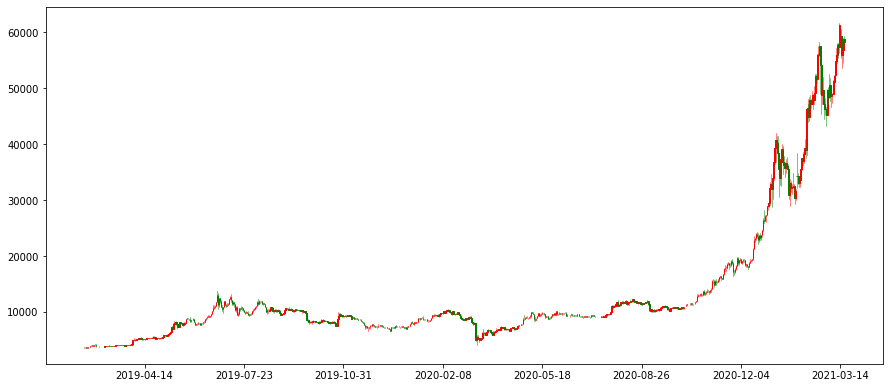

In [107]:
#畫K線圖
ma_10 = moving_average(df,10)
ma_50 = moving_average(df,50)
length = len(df)
figure = plt.figure(facecolor='white',figsize=(15,10))
axl = plt.subplot2grid((6,4),(0,0),rowspan=4,colspan=4,facecolor='white')
candlestick_ohlc(axl,data_plot.values,width=0.5,colorup='red',colordown='green')
axl.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))